In [1]:
# # 필요한 패키지 설치
# !pip install yfinance
# !pip install pandas-datareader
# !pip install pykrx

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import pykrx as krx
from pykrx import stock # pykrx:패키지, import stock:모듈

# LSTM을 활용한 주식가격 예측

# Pykrx

In [3]:
df = stock.get_market_ohlcv_by_date('20100101','20210101', '005930')
df.fillna(method='ffill', inplace=True)   #앞에서 가져온다
df.fillna(method='bfill', inplace=True)   #뒤에서 가져온다

In [4]:
df.shape  #(2714, 5)

(2714, 5)

In [5]:
df.head()

,시가,고가,저가,종가,거래량
날짜,,,,,
2010-01-04,16060,16180,16000,16180,239271
2010-01-05,16520,16580,16300,16440,559219
2010-01-06,16580,16820,16520,16820,459755
2010-01-07,16820,16820,16260,16260,443237
2010-01-08,16400,16420,16120,16420,295798


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2714 entries, 2010-01-04 to 2020-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   시가      2714 non-null   int32
 1   고가      2714 non-null   int32
 2   저가      2714 non-null   int32
 3   종가      2714 non-null   int32
 4   거래량     2714 non-null   int32
dtypes: int32(5)
memory usage: 74.2 KB


In [7]:
# #날짜모양의 글자다  '2019-01-01'  --> date타입
# df['날짜'] = pd.to_datetime(df['날짜'], format='%Y-%m-%d')
# df.set_index('날짜')

<AxesSubplot:xlabel='날짜'>

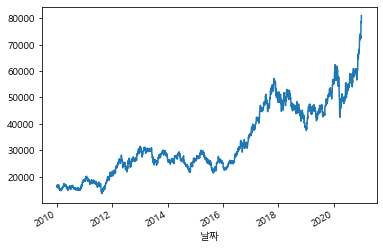

In [8]:
df["종가"].plot()

<AxesSubplot:xlabel='날짜'>

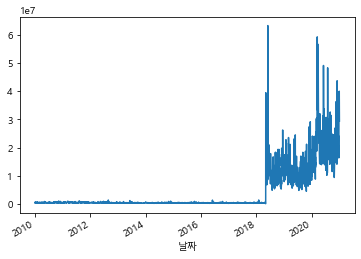

In [9]:
df["거래량"].plot()

<AxesSubplot:>

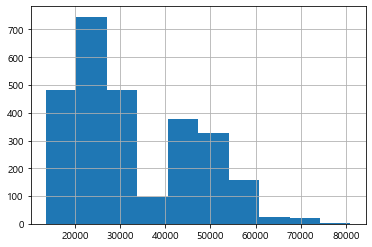

In [10]:
df['종가'].hist()

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaler = scaler.fit_transform(df)
sdf = pd.DataFrame(df_scaler)
sdf.columns = df.columns
sdf.index = df.index

In [12]:
sdf.head()

,시가,고가,저가,종가,거래량
날짜,,,,,
2010-01-04,0.203291,0.199016,0.204604,0.038279,0.003769
2010-01-05,0.209114,0.203936,0.208440,0.042136,0.008808
2010-01-06,0.209873,0.206888,0.211253,0.047774,0.007241
2010-01-07,0.212911,0.206888,0.207928,0.039466,0.006981
2010-01-08,0.207595,0.201968,0.206138,0.041840,0.004659


In [13]:
print(sdf.shape[0],  int(sdf.shape[0] * 0.2))
split_idx =  int(sdf.shape[0] * 0.2)

2714 542


In [50]:
train = sdf.iloc[:-542]
test = sdf.iloc[-542:] 

In [51]:
print(train.shape, test.shape)

(2172, 5) (542, 5)


In [52]:
def make_dataset(data, label, window_size=20): # data: 문제지 / label: 정답지
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


In [53]:
# 종가를 맞출것. 종가:y , 종가제외:X
y_train = train['종가']
X_train = train.drop('종가',axis=1)
y_test = test['종가']
X_test = test.drop('종가',axis=1)


X_train_arr, y_train_arr = make_dataset(X_train,y_train)
X_test_arr, y_test_arr = make_dataset(X_test,y_test)

In [54]:
print(X_train_arr.shape, y_train_arr.shape) # 20: windowsize , 20개씩 잡힌 4개 , 컬럼 2152 전체데이터개수
print(X_test_arr.shape, y_test_arr.shape)

(2152, 20, 4) (2152,)
(522, 20, 4) (522,)


In [55]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [56]:
# model = Sequential()
# input_shape = (X_train_arr.shape[1],X_train_arr.shape[2])
# model.add(LSTM(20, activation='relu', return_sequences= True, input_shape=input_shape))
# model.add(Dense(1))

In [57]:
# lstm 부분, 확인하고 삭제
model = Sequential()
# model.add(Input())
model.add(LSTM(20, activation='relu',return_sequences= True, input_shape = (X_train_arr.shape[1], X_train_arr.shape[2])))
model.add(Dense(1))


In [58]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [59]:
# checkpnt = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
estop = EarlyStopping(monitor='val_loss', patience=4)

In [60]:
model.fit(X_train_arr,y_train_arr, epochs=100,
                validation_split=0.1, # 사이즈: 개수 정해서 줌,  split: 10% 비율로
                callbacks = [estop])

Epoch 1/100
61/61 [==============================] - 3s 25ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 2/100
61/61 [==============================] - 1s 13ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 3/100
61/61 [==============================] - 1s 16ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 4/100
61/61 [==============================] - 1s 15ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 5/100
61/61 [==============================] - 1s 18ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 6/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/100
61/61 [==============================] - 1s 12ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 8/100
61/61 [==============================] - 1s 14ms/step - loss: 0.

In [61]:
pred = model.predict(X_test_arr)

In [65]:
# print(y_test_arr[:5], pred[:5])

In [72]:
pred.mean(axis=1).shape

(522, 1)

No handles with labels found to put in legend.


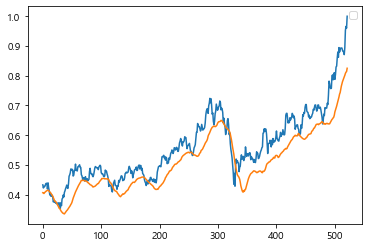

In [76]:
plt.plot(y_test_arr)
plt.plot(pred.mean(axis=1))
plt.legend()
plt.show()